# Initialization

In [1]:
import os
os.getcwd()

'/Users/lengyueshuang/Desktop/NLP'

In [2]:
!pip install deep_translator

# Load data

In [3]:
import pandas as pd

data = pd.read_excel(r'./data/dataset.xlsx',engine='openpyxl')
data.head()

,content,datetime
0,Saya sangat suka infinity kingdom,2020-11-05 06:37:53
1,Excelentes gráficos distintos héroes divertido...,2020-07-24 22:33:21
2,awesome ... just make us control the troops on...,2020-05-22 14:12:02
3,muy entretenido y adictivo,2020-05-17 14:29:07
4,great game and beautiful graphic,2020-05-16 07:06:23


### remove NA and duplicates

In [4]:
# deal with missing data and duplicated data
data = data.drop_duplicates()
data = data[data.content.notna()]
data = data[data.content.apply(lambda x: len(x.split())>0)]

In [6]:
data = data[data.content.apply(lambda x: len(x.split())>1)]

# Translate

In [7]:
from deep_translator import GoogleTranslator

data.content = data.content.apply(lambda x: GoogleTranslator(source='auto', target='en').translate(x))
data.to_csv(r'./data/dataset_translated.csv',index=False)

# Which character is popular?

In [10]:
character = pd.read_csv(r'./data/infinity_kingdom_character_list.csv')
character_name = character.Character.apply(lambda x: x.split(' ')[0]).tolist()

In [11]:
from collections import Counter

c = Counter()
for line in data.content.tolist():
  for word in line.split(' '):
    if word in character_name:
      c[word] = c[word] + 1

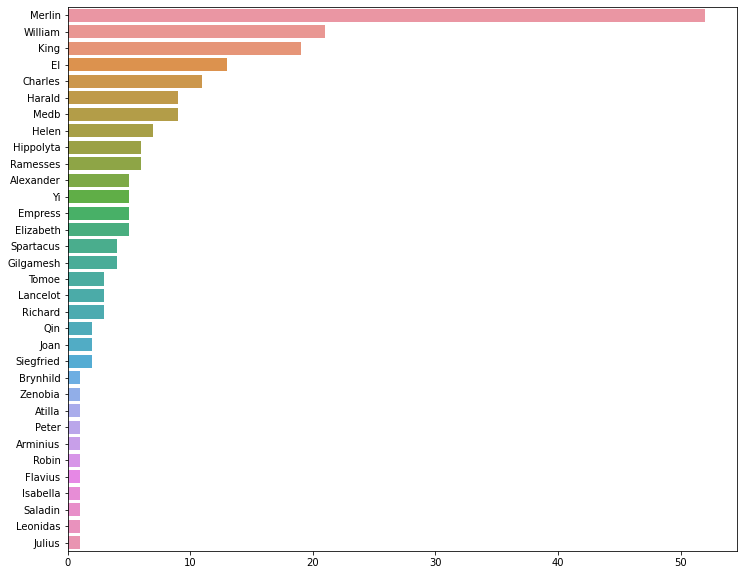

In [12]:
counts = c.most_common()[:-1]

import matplotlib.pyplot as plt
import seaborn as sns

x, y = [], []
for word, count in counts:
    x.append(word)
    y.append(count)
plt.figure(figsize=(12,10))
sns.barplot(x=y, y=x)
plt.show()

From plot above, we can tell that Merlin is the most popular character. 

# Sentiment Analasis

Since we do not have labeled data, it is hard for us to use more sophiscated models like BERT to do sentiment analysis. Therefore, I use function from NLTK to predict sentiment directly. It is indeed less acurate, but still can provide us some information.

In [13]:
# emoji treatment

import re
import pickle
import pathlib
import tensorflow as tf

data_dir = pathlib.Path('./data')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'Emoji_Dict.p',
      origin="https://drive.google.com/open?id=1G1vIkkbqPBYPKHcQ8qy0G2zkoab2Qv4v",
      extract=False,
      cache_dir='.', cache_subdir='data')   

with open('./data/Emoji_Dict.p', 'rb') as fp:
    Emoji_Dict = pickle.load(fp)

Emoji_Dict = {v:k for k, v in Emoji_Dict.items()}

def convert_emojis_to_word(text):
    for emot in Emoji_Dict:
        text = re.sub(r'('+emot+')', "_".join(Emoji_Dict[emot].replace(",","").replace(":","").split())+' ', text)
    return text

def remove_emojis(text):
    for emot in Emoji_Dict:
        text = re.sub(r'('+emot+')', ' ', text)
    return text

with open('./data/Emoticon_Dict.p', 'rb') as fp:
    Emoticon_Dict = pickle.load(fp)
    
def convert_emoticons(text):
    for emot in Emoticon_Dict:
        text = re.sub(u'('+emot+')', "_".join(Emoticon_Dict[emot].replace(",","").split())+' ', text)
    return text

def remove_emoticons(text):
    for emot in Emoticon_Dict:
        text = re.sub(u'('+emot+')', ' ', text)
    return text

In [26]:
from nltk import sent_tokenize, word_tokenize

def clean_sentiment(text):
    # Guarantee the '.' can be seens as a sentence sep
    text = re.sub(r'([^0-9])\.([^0-9])', r'\1. \2', text)
    # Replace more than 2 '-' with '.' to avoid sentence splitting
    text = re.sub("-{2,}", ".", text)
    text = re.sub('_',' ',text)
    # text = re.sub('.{2,}',' ',text)
    # will replace the html characters with " "
    text = re.sub("<br />", " ",text)
    text=' '.join([i for i in text.split() if not i.startswith('https://')])    
    # replace newline with space
    text = re.sub("\n"," ",text)
    
    tokenized_text = sent_tokenize(text)
    
    return tokenized_text   


sentence = [j for i in data.content.apply(lambda x: clean_sentiment(x)).tolist() for j in i] 

In [31]:
sentiment = pd.DataFrame({'reviews':sentence})

In [32]:
def convert_emo(text):
    text = convert_emojis_to_word(text)
    text = convert_emoticons(text)
    return text

sentiment['for_sent'] = sentiment.reviews.apply(lambda x: convert_emo(x))

In [27]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    if ss['neu'] == 1:
        return 0
    if ss['neg'] > ss['pos']:
        return -ss['neg']
    else:
        return ss['pos']    

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lengyueshuang/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [33]:
sentiment['score'] = sentiment['for_sent'].apply(lambda x: get_vader_score(x))
sentiment.head()

,reviews,for_sent,score
0,I really like infinity kingdom,I really like infinity kingdom,0.482
1,Excellent graphics different fun and interesti...,Excellent graphics different fun and interesti...,0.812
2,awesome .,awesome .,1.000
3,.. just make us control the troops on map plls,.. just make us control the troops on map plls,0.000
4,very entertaining and addictive,very entertaining and addictive,0.516


In [34]:
n1 = sentiment[sentiment.score.apply(lambda x: x>0)].shape[0]
print('We have %d positive feedbacks'% n1)
n2 = sentiment[sentiment.score.apply(lambda x: x==0)].shape[0]
print('We have %d neutral feedbacks'% n2)
n3 = sentiment[sentiment.score.apply(lambda x: x<0)].shape[0]
print('We have %d negative feedbacks'% n3)

We have 1244 positive feedbacks
We have 1179 neutral feedbacks
We have 344 negative feedbacks


Overall, we have quite positve feedbacks.

# LDA

Let's dig deeper to see what part of the game people like and what part they do not like.

In [35]:
import re
import string

def clean_text(text):
    # add space in front of Capital letter
    text = re.sub(r'(\w)([A-Z])',r'\1 \2',text)    
    # lowercase, except for characters
    text = ' '.join([i.lower() for i in text.split(' ')])
    # remove the punctuations
    text = text.translate(str.maketrans(' ',' ',string.punctuation))
    # consider only alphabets
    text = re.sub('[^a-zA-Z]',' ',text)      
    # remove ID: xxxxxxx
    text = re.sub("x{5,}"," ",text) 
    # remove words like 'soooooo'
    text = re.sub(r"(.)\1{3,}", r"\1", text)
    
    
    return ' '.join(text.split())


In [40]:
def replace_character(text):
    return ' '.join([i if i not in character_name else 'character' for i in text.split()])          

In [37]:
# remove stopwords
import nltk
nltk.download('stopwords')

def remove_stop(x): 
    stopwords_list = nltk.corpus.stopwords.words('english')
    return [word for word in x.split() if (word not in stopwords_list) and len(word)>2]  

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lengyueshuang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')

def preprocessing_lda(text):  
    text = remove_emojis(text)
    text = remove_emoticons(text)
    text = clean_text(text)
    text = replace_character(text)
    text = remove_stop(text)

    wordnet_lemmatizer = WordNetLemmatizer()
    text = [wordnet_lemmatizer.lemmatize(word) for word in text] # do lemmatization
      
    # we only need noun and some verb to deduce topic
    tag = nltk.pos_tag(text)
    lemmatizer = WordNetLemmatizer()
    verb_set = {'VBD','VBG','VBN','VBZ','VBP'}
    noun_set = {'NN','NNS','NNPS'}
    tag = [list(x) for x in tag]

    tem_tag = []
    for j in range(len(tag)):
        if tag[j][1] in verb_set:
            tem_tag.append(lemmatizer.lemmatize(tag[j][0], pos='v'))
        elif tag[j][1] in noun_set:
            tem_tag.append(lemmatizer.lemmatize(tag[j][0], pos='n'))

    return ' '.join([i for i in tem_tag])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lengyueshuang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lengyueshuang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [42]:
sentiment['lda_text'] = sentiment.reviews.apply(lambda x: preprocessing_lda(x))

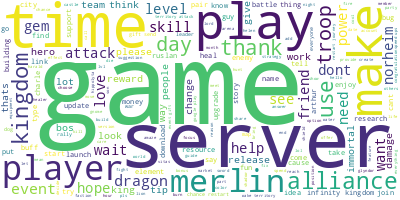

In [45]:
# Do visualization first
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(sentiment['lda_text'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [50]:
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

def plot_top_words(n_components, model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(int(n_components/5), 5, figsize=(30, 10*int(n_components/5)), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()    
    
    
def get_lda_topic(data_samples,n_components):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=2,
                                       max_features=1000,
                                       stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(data_samples)

    # LDA model
    lda = LatentDirichletAllocation(n_components=n_components, max_iter=25,
                                    learning_method='batch',
                                    random_state=0)
    lda.fit(tfidf)

    tf_feature_names = tfidf_vectorizer.get_feature_names()
    plot_top_words(n_components, lda, tf_feature_names, 20, 'Topics in LDA model')

### First, let's see what part people like

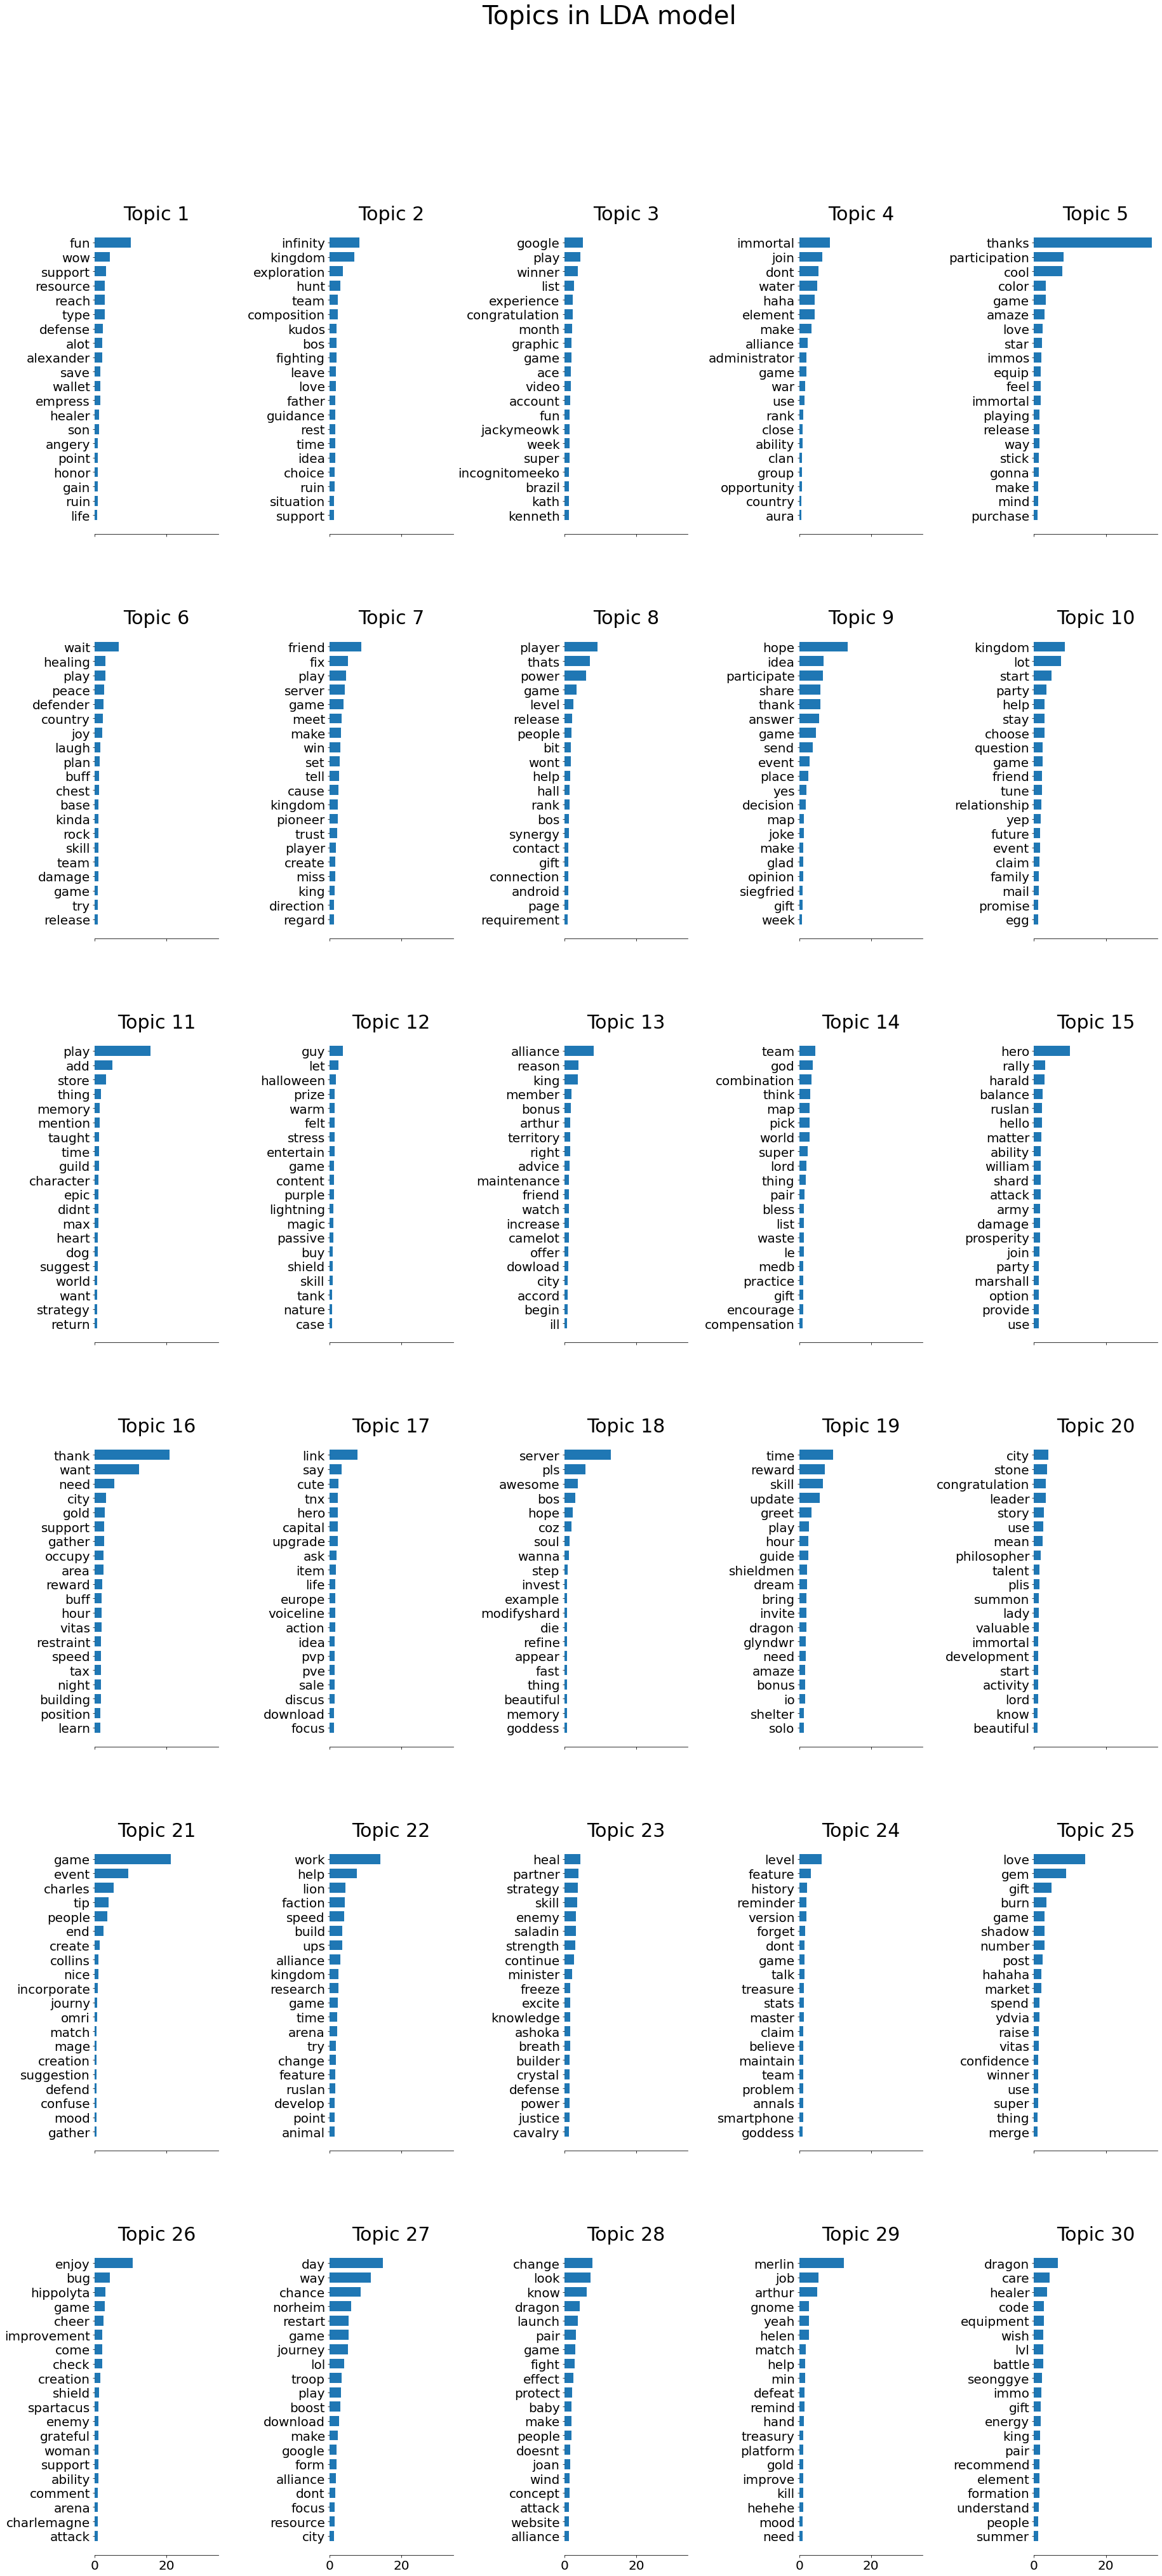

In [52]:
positive_reviews = sentiment.loc[sentiment.score>0,'lda_text']
get_lda_topic(positive_reviews,30)

It is quite hard to tell, but it does give us some clues. For example, 
1. topic 10 has words like 'party', 'friend', so we can infer that one reason people like it is because they can play it at party and share it with friends.
2. topic 3 has key words like graphics, so some people like it maybe due to its graphics.
3. many character names mentioned a lot, so people like our characters.
4. there are other key words like 'strategy', 'story', 'gift', 'equipment' which are also mentioned.

### Now, let's see what part of the game people complain the most.

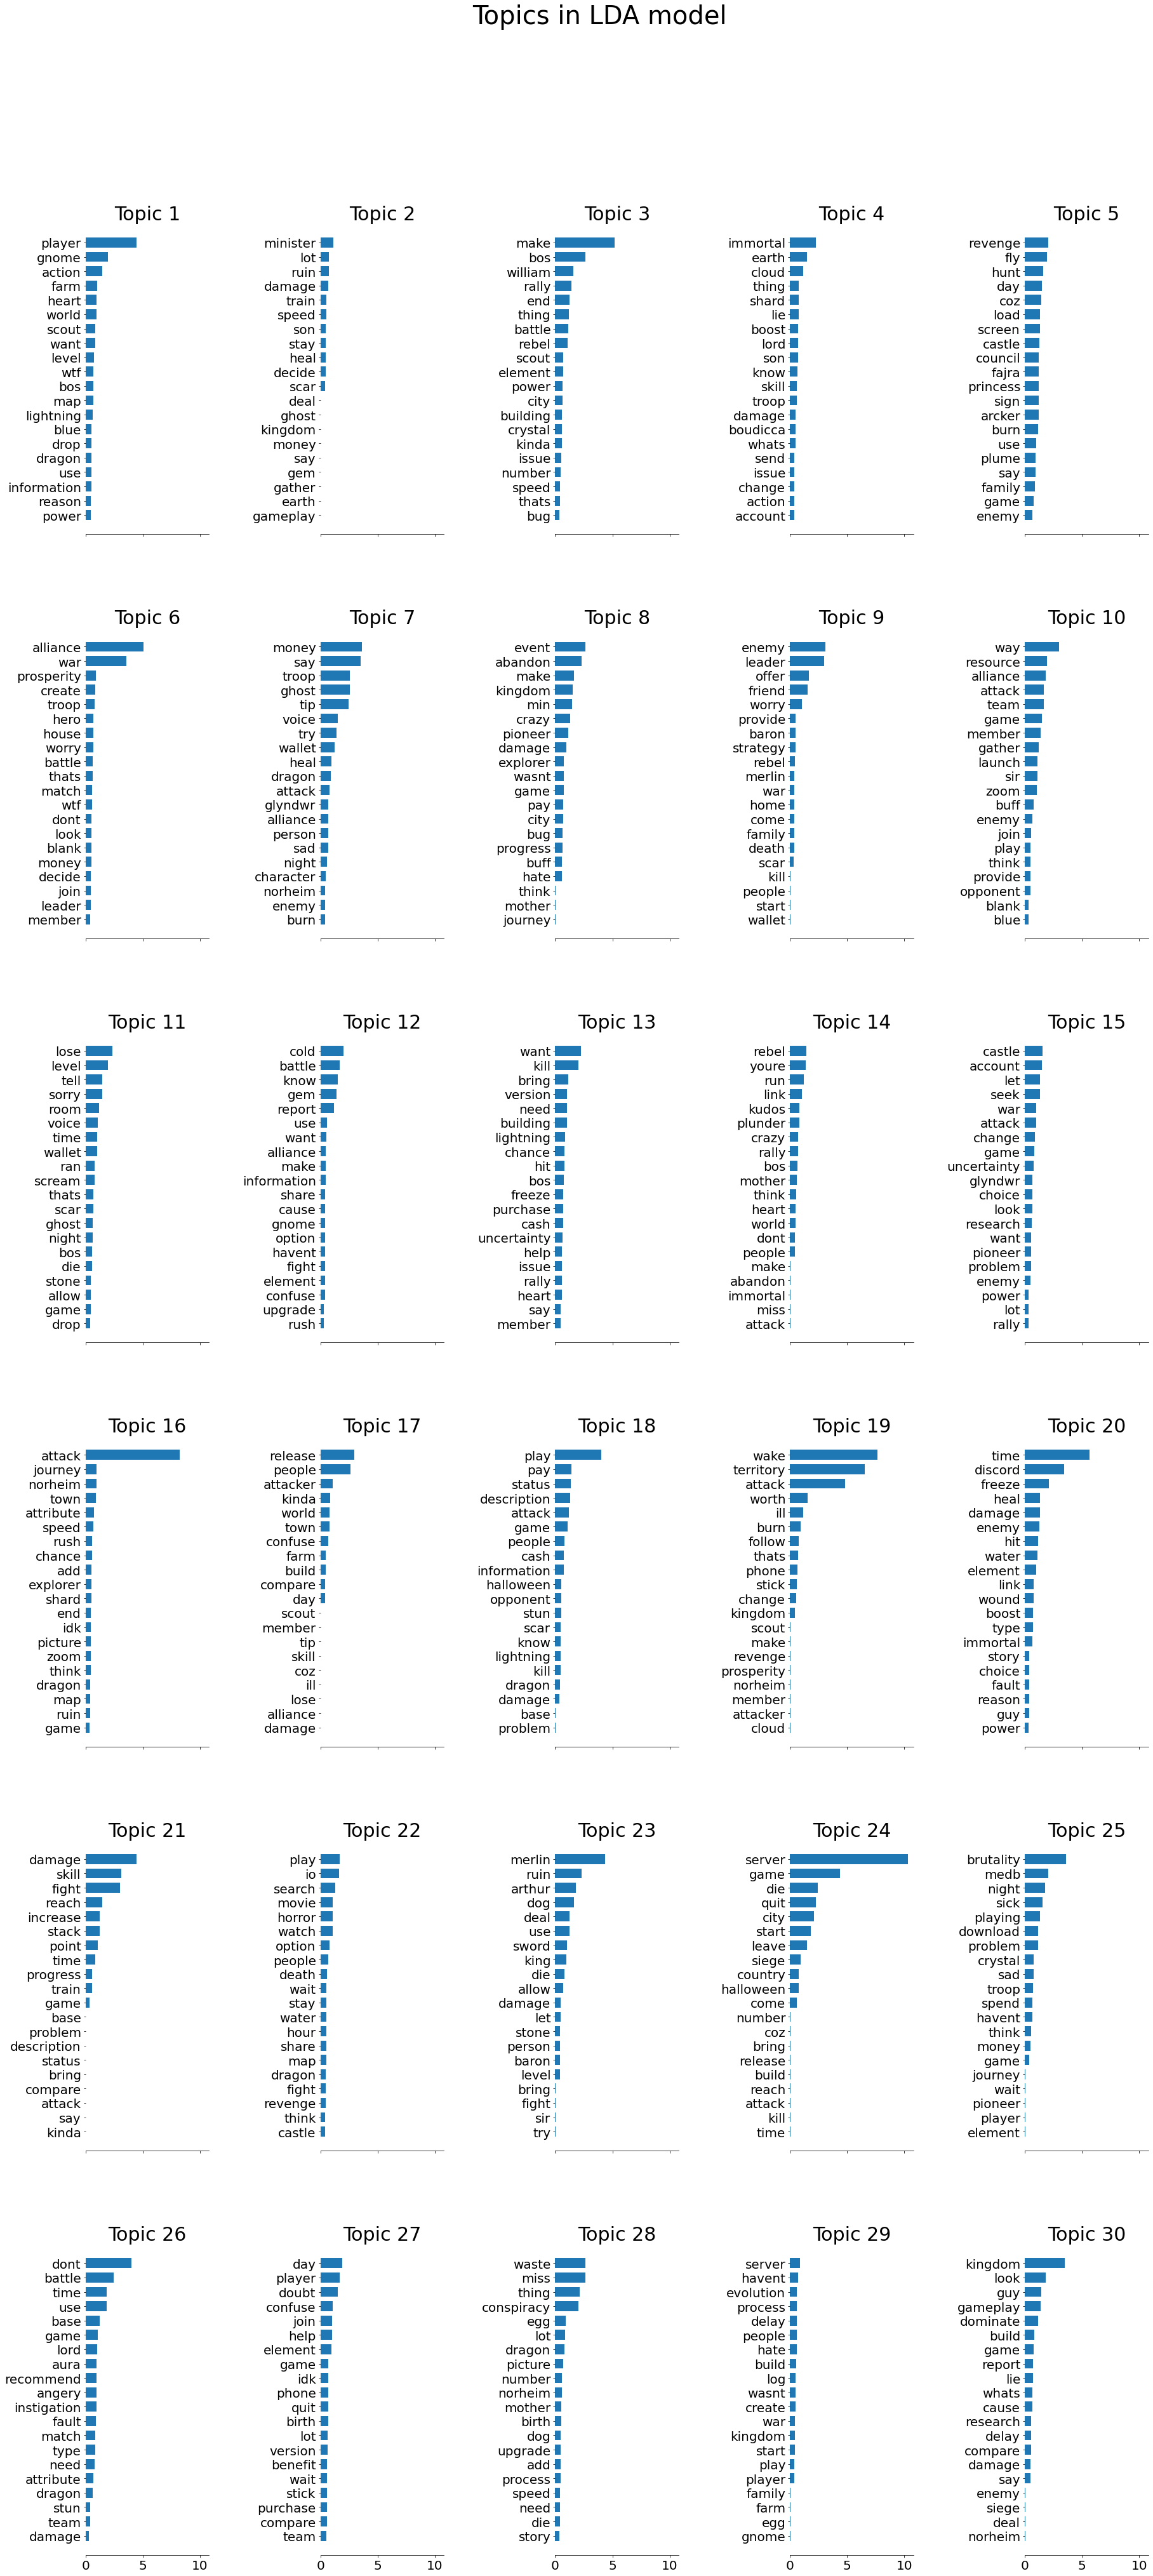

In [54]:
positive_reviews = sentiment.loc[sentiment.score<0,'lda_text']
get_lda_topic(positive_reviews,30)

from topic 24 and 25, we can see that there might be some download problem and server problem.